In [1]:
import torch
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import gc

# Plotly visualizations
from plotly import tools
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# plotly.tools.set_credentials_file(username='AlexanderBach', api_key='o4fx6i1MtEIJQxfWYvU1')


# For oversampling Library (Dealing with Imbalanced Datasets)
from imblearn.over_sampling import SMOTE
from collections import Counter

# Other Libraries
import time
%matplotlib inline

df1 = pd.read_csv('/kaggle/input/lendingclub/LoanStats_securev1_2019Q1.csv', low_memory=False,header = 1) # Q1
df2 = pd.read_csv('/kaggle/input/lendingclub/LoanStats_securev1_2019Q2.csv', low_memory=False,header = 1) # Q2
df3 = pd.read_csv('/kaggle/input/lendingclub/LoanStats_securev1_2019Q3.csv', low_memory=False,header = 1) # Q3
df = pd.concat([df1,df2,df3],axis=0)
df.head() # Take a look for the data

Using TensorFlow backend.


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,149203043,NaN,24000.0,24000.0,24000.0,60 months,13.90%,557.20,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,149461986,NaN,24000.0,24000.0,24000.0,60 months,20.00%,635.86,D,D2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,149477700,NaN,15000.0,15000.0,15000.0,36 months,17.97%,542.07,D,D1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,149512381,NaN,7800.0,7800.0,7800.0,36 months,11.02%,255.44,B,B2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,149512743,NaN,30000.0,30000.0,30000.0,60 months,14.74%,709.62,C,C2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
df = df.dropna(axis = 0,how = 'all').reset_index(drop=True) ## Drop the rows that all null
df = df.dropna(axis = 1,how = 'all') # Drop the columns all null

In [3]:
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,149203043,24000.0,24000.0,24000.0,60 months,13.90%,557.20,C,C1,Budget analyst,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,149461986,24000.0,24000.0,24000.0,60 months,20.00%,635.86,D,D2,operating tech,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,149477700,15000.0,15000.0,15000.0,36 months,17.97%,542.07,D,D1,Administrative Assistant,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,149512381,7800.0,7800.0,7800.0,36 months,11.02%,255.44,B,B2,Distribution manager,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,149512743,30000.0,30000.0,30000.0,60 months,14.74%,709.62,C,C2,Research Assistant II,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info(),df.shape ## We have 143038 record in the Q3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389855 entries, 0 to 389854
Columns: 148 entries, id to settlement_term
dtypes: float64(110), object(38)
memory usage: 440.2+ MB


(None, (389855, 148))

In [5]:
del df1,df2,df3 # Deleting useless data
gc.collect()

# Copy of the dataframe
original_df = df.copy()

### Getting some information by the EDA

In [6]:
df = df.rename(columns={"loan_amnt": "loan_amount", 
                        "funded_amnt": "funded_amount", 
                        "funded_amnt_inv": "investor_funds",
                       "int_rate": "interest_rate",  # Every individual get different interest_rate
                        "annual_inc": "annual_income"}) ## This is the feature we more focus on!

# Drop irrelevant columns
irrelevant_features = ['id', 'emp_title', 'url', 'zip_code', 'title']  # Based on the code book
df.drop(irrelevant_features, axis=1, inplace=True) ## 

In [7]:
df = df.dropna(subset = ["loan_amount"],axis = 0).reset_index(drop=True) # Found some missing values in loan_amout, and it is impossible that happen!! So drop it!!

Text(0.5, 1.0, 'Total committed by Investors')

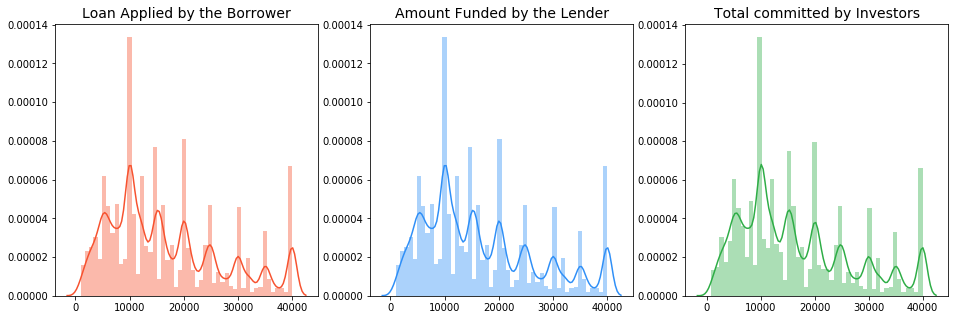

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

loan_amount = df["loan_amount"].values
funded_amount = df["funded_amount"].values
investor_funds = df["investor_funds"].values

sns.distplot(loan_amount, ax=ax[0], color="#F7522F")
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.distplot(funded_amount, ax=ax[1], color="#2F8FF7")
ax[1].set_title("Amount Funded by the Lender", fontsize=14)
sns.distplot(investor_funds, ax=ax[2], color="#2EAD46")
ax[2].set_title("Total committed by Investors", fontsize=14)

## Above are the distribution of the amount of lending money
* 10000 are the most popular amount in the dataset

In [9]:
df['issue_d'].head() # the loan issued date 

0    Mar-2019
1    Mar-2019
2    Mar-2019
3    Mar-2019
4    Mar-2019
Name: issue_d, dtype: object

In [10]:
# Fransfer the month from string to month
## string mar >>>> int 3
df['month'] = pd.to_datetime(df['issue_d']).dt.month

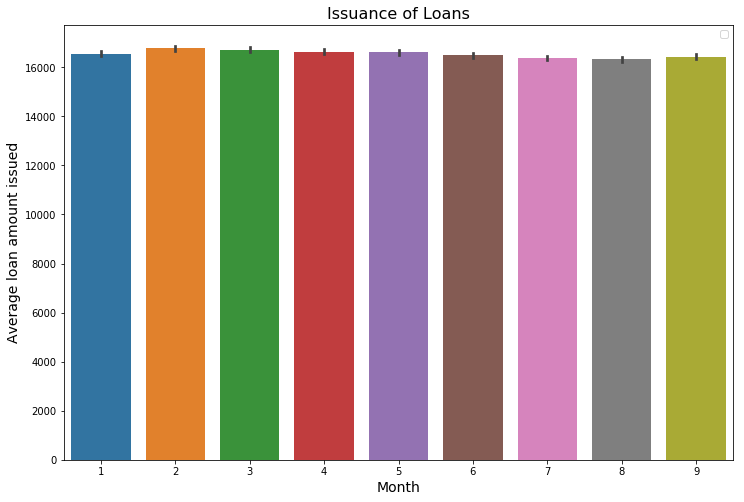

In [11]:
plt.figure(figsize=(12,8))
sns.barplot('month', 'loan_amount', data=df, palette='tab10')
plt.title('Issuance of Loans', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average loan amount issued', fontsize=14)
plt.legend()

## The monthly average loan 
* The amount in the 2019 is around 16000 from January to September

In [12]:
## Let us to get a close look on the quality of the loan
df["loan_status"].value_counts()

Current               354666
Fully Paid             25160
Late (31-120 days)      4513
Charged Off             2752
In Grace Period         1740
Late (16-30 days)       1016
Default                    2
Name: loan_status, dtype: int64

In [13]:
# In orignal data, those 4 values represent the bad loans
bad_loan = ["Charged Off",
            "In Grace Period", 
            "Late (16-30 days)",
            "Late (31-120 days)"] ## These status demonstrate that we may could not get the money back

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
df['loan_condition'] = df['loan_status'].apply(lambda x: loan_condition(x))

In [14]:
df.loan_condition.value_counts() # It seems we only have 1% bad loan 

Good Loan    379828
Bad Loan      10021
Name: loan_condition, dtype: int64

[Text(0, 0.5, '(%)')]

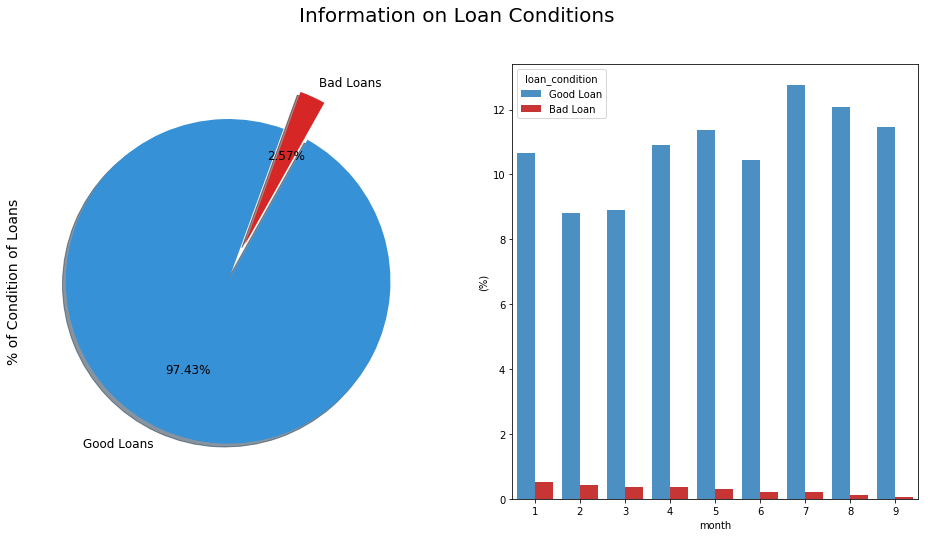

In [15]:
f, ax = plt.subplots(1,2, figsize=(16,8))
colors = ["#3791D7", "#D72626"]
labels ="Good Loans", "Bad Loans"

plt.suptitle('Information on Loan Conditions', fontsize=20)
df["loan_condition"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)
ax[0].set_ylabel('% of Condition of Loans', fontsize=14)
palette = ["#3791D7", "#E01E1B"]
sns.barplot(x="month", y="loan_amount", hue="loan_condition", data=df, palette=palette, estimator=lambda x: len(x) / len(df) * 100)
ax[1].set(ylabel="(%)")

## From the graphs
* It seems that there is a cycle in the amount of loan
* And the lending club are getting well on the risk management.

In [16]:
# Make a list with each of the regions by state.
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'

df['region'] = df['addr_state'].apply(lambda x : finding_regions(x)) # Analysis by region would be more meaningful and useful than state, lower fluctuation by noise

In [17]:
df['complete_date'] = pd.to_datetime(df['issue_d'])

group_dates = df.groupby(['complete_date', 'region'], as_index=False).sum()

group_dates['issue_d'] = [month.to_period('M') for 
                          month in group_dates['complete_date']]

group_dates = group_dates.groupby(['issue_d', 'region'], as_index=False).sum()
group_dates = group_dates.groupby(['issue_d', 'region'], as_index=False).sum()
group_dates['loan_amount'] = group_dates['loan_amount']/1000


df_dates = pd.DataFrame(data=group_dates[['issue_d','region','loan_amount']])
df_dates.head()

,issue_d,region,loan_amount
0,2019-01,MidWest,121524.200
1,2019-01,NorthEast,156310.175
2,2019-01,SouthEast,180815.375
3,2019-01,SouthWest,90705.075
4,2019-01,West,172157.175


Text(0.5, 1.0, 'Loans issued by Region')

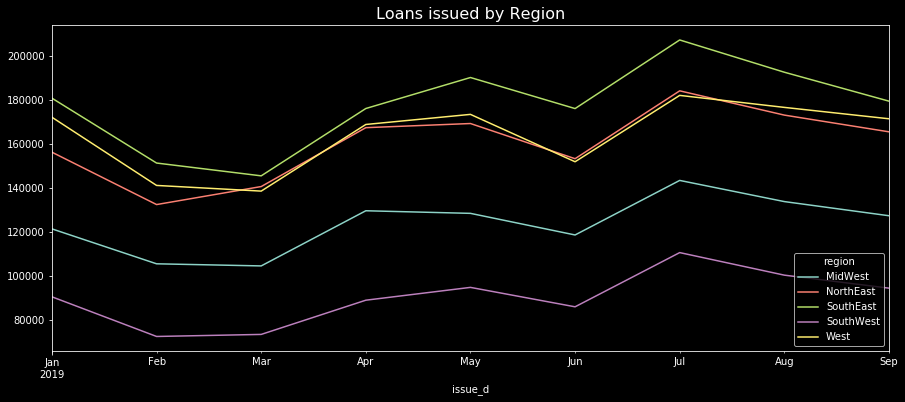

In [18]:
plt.style.use('dark_background')
cmap = plt.cm.Set3

by_issued_amount = df_dates.groupby(['issue_d', 'region']).loan_amount.sum()
by_issued_amount.unstack().plot(stacked=False, colormap=cmap, grid=False, legend=True, figsize=(15,6))

plt.title('Loans issued by Region', fontsize=16)

### Less people tend to borrow money ?

## Trend in the those 5 region are similiar

In [19]:
### Transform the 
def employ_year_int(status):
    #print(status)
    if type(status) == str:
        return int("".join([i for i in status if i.isdigit()]))
    else:
        return 0
df['emp_length_int'] = df['emp_length'].apply(lambda x: employ_year_int(x))


In [20]:
def interest_rate_float(status):
    #print(status)
    if type(status) == str:
        return float(status[:-1])
    else:
        return 0
df['interest_rate'] = df['interest_rate'].apply(lambda x: interest_rate_float(x))

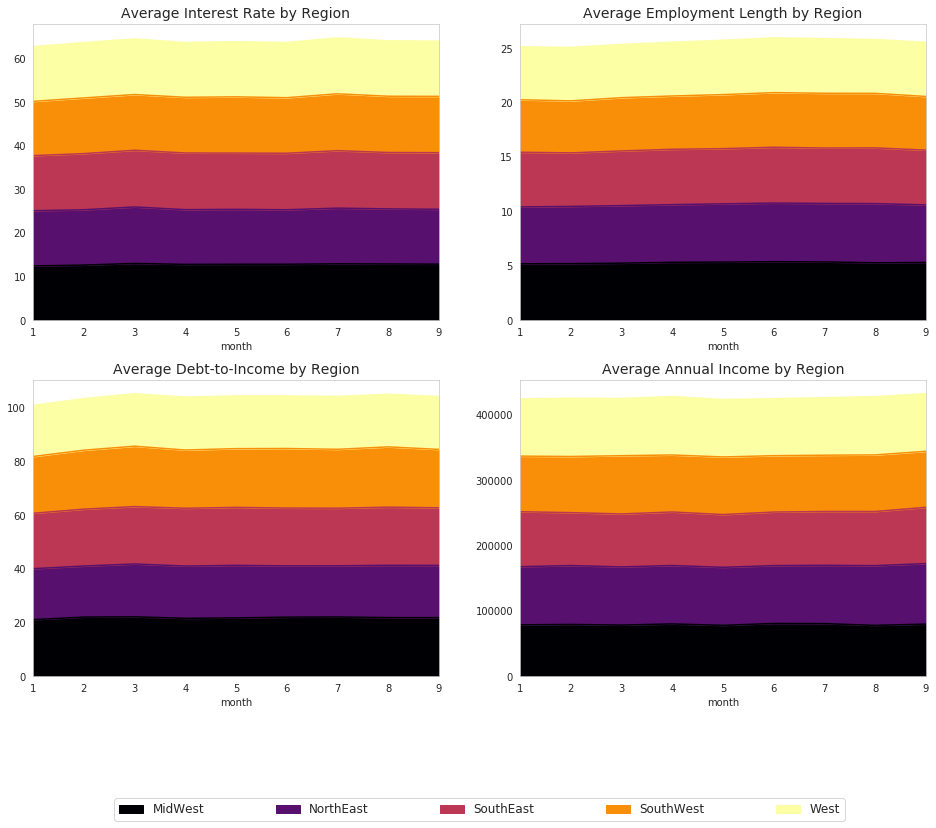

In [21]:
sns.set_style('whitegrid')

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
cmap = plt.cm.inferno

by_interest_rate = df.groupby(['month', 'region']).interest_rate.mean()
by_interest_rate.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, legend=False, ax=ax1, figsize=(16,12))
ax1.set_title('Average Interest Rate by Region', fontsize=14)


by_employment_length = df.groupby(['month', 'region']).emp_length_int.mean()
by_employment_length.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, legend=False, ax=ax2, figsize=(16,12))
ax2.set_title('Average Employment Length by Region', fontsize=14)


by_dti = df.groupby(['month', 'region']).dti.mean()
by_dti.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, legend=False, ax=ax3, figsize=(16,12))
ax3.set_title('Average Debt-to-Income by Region', fontsize=14)

by_income = df.groupby(['month', 'region']).annual_income.mean()
by_income.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, ax=ax4, figsize=(16,12))
ax4.set_title('Average Annual Income by Region', fontsize=14)
ax4.legend(bbox_to_anchor=(-1.0, -0.5, 1.8, 0.1), loc=10,prop={'size':12},
           ncol=5, mode="expand", borderaxespad=0.)

## Analysis on region and interest
* I did not find something intersting

In [22]:
## than focus on the bad loans
badloans_df = df.loc[df["loan_condition"] == "Bad Loan"]
print(badloans_df.shape)

# loan_status cross
loan_status_cross = pd.crosstab(badloans_df['region'], badloans_df['loan_status']).apply(lambda x: x/x.sum() * 100)
number_of_loanstatus = pd.crosstab(badloans_df['region'], badloans_df['loan_status'])


# Round our values
loan_status_cross['Charged Off'] = loan_status_cross['Charged Off'].apply(lambda x: round(x, 2))
loan_status_cross['In Grace Period'] = loan_status_cross['In Grace Period'].apply(lambda x: round(x, 2))
loan_status_cross['Late (16-30 days)'] = loan_status_cross['Late (16-30 days)'].apply(lambda x: round(x, 2))
loan_status_cross['Late (31-120 days)'] = loan_status_cross['Late (31-120 days)'].apply(lambda x: round(x, 2))


number_of_loanstatus['Total'] = number_of_loanstatus.sum(axis=1) 
number_of_loanstatus

(10021, 148)


loan_status,Charged Off,In Grace Period,Late (16-30 days),Late (31-120 days),Total
region,,,,,
MidWest,427,283,146,734,1590
NorthEast,585,416,242,1061,2304
SouthEast,712,425,239,1115,2491
SouthWest,351,207,135,558,1251
West,677,409,254,1045,2385


## In the 2019 Q1-Q3 there are over 10000 bad loan record

In [23]:
charged_off = loan_status_cross['Charged Off'].values.tolist()
grace_period = loan_status_cross['In Grace Period'].values.tolist()
short_pay = loan_status_cross['Late (16-30 days)'] .values.tolist()
long_pay = loan_status_cross['Late (31-120 days)'].values.tolist()



charged = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= charged_off,
    name='Charged Off',
    marker=dict(
        color='rgb(192, 148, 246)'
    ),
    text = '%'
)

grace = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= grace_period,
    name='Grace Period',
    marker = dict(
        color='rgb(147, 147, 147)'
    ),
    text = '%'
)

short_pays = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= short_pay,
    name='Late Payment (16-30 days)', 
    marker = dict(
        color='rgb(246, 157, 135)'
    ),
    text = '%'
)

long_pays = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= long_pay,
    name='Late Payment (31-120 days)',
    marker = dict(
        color = 'rgb(238, 76, 73)'
        ),
    text = '%'
)




data = [charged, grace, short_pays, long_pays]
layout = go.Layout(
    barmode='stack',
    title = '% of Bad Loan Status by Region',
    xaxis=dict(title='US Regions')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

## Different region has different poportion in bad_loan
* The regions of the West, NorthEast and SouthEast  had a higher percentage in most of the b "bad" loan statuses(Charged off).

In [24]:
by_loan_amount = df.groupby(['region','addr_state'], as_index=False).loan_amount.sum()
by_interest_rate = df.groupby(['region', 'addr_state'], as_index=False).interest_rate.mean()
by_income = df.groupby(['region', 'addr_state'], as_index=False).annual_income.mean()

# Take the values to a list for visualization purposes.
states = by_loan_amount['addr_state'].values.tolist()
average_loan_amounts = by_loan_amount['loan_amount'].values.tolist()
average_interest_rates = by_interest_rate['interest_rate'].values.tolist()
average_annual_income = by_income['annual_income'].values.tolist()

from collections import OrderedDict

# Figure Number 1 (Perspective for the Business Operations)
metrics_data = OrderedDict([('state_codes', states),
                            ('issued_loans', average_loan_amounts),
                            ('interest_rate', average_interest_rates),
                            ('annual_income', average_annual_income)])
                     
metrics_df = pd.DataFrame.from_dict(metrics_data)
metrics_df = metrics_df.round(decimals=2)
metrics_df.head()

,state_codes,issued_loans,interest_rate,annual_income
0,IL,260378325.0,12.73,86206.30
1,IN,105803025.0,12.86,76503.13
2,KS,53081200.0,12.83,80499.63
3,MI,151777650.0,12.94,78567.80
4,MN,103870100.0,12.81,81114.39


In [25]:
for col in metrics_df.columns:
    metrics_df[col] = metrics_df[col].astype(str)
    
scl = [[0.0, 'rgb(210, 241, 198)'],[0.2, 'rgb(188, 236, 169)'],[0.4, 'rgb(171, 235, 145)'],\
            [0.6, 'rgb(140, 227, 105)'],[0.8, 'rgb(105, 201, 67)'],[1.0, 'rgb(59, 159, 19)']]

## To html format
metrics_df['text'] = metrics_df['state_codes'] + '<br>' +\
'Average loan interest rate: ' + metrics_df['interest_rate'] + '<br>'+\
'Average annual income: ' + metrics_df['annual_income'] 

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = metrics_df['state_codes'],
        z = metrics_df['issued_loans'], 
        locationmode = 'USA-states', # US map
        text = metrics_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "$s USD")
        ) ]

layout = dict(
    title = 'Lending Clubs Issued Loans <br> (A Perspective for the Business Operations)',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

* California, Texas, New York and Florida are the states in which the highest amount of loans were issued.
* Interesting enough, all four states have a approximate interest rate of 13% which is at the same level of the average interest rate for all states (13.24%)
* California, Texas and New York are all above the average annual income (with the exclusion of Florida), this might give possible indication why most loans are issued in these states.

In [26]:
# Low income category: Borrowers that have an annual income lower or equal to 100,000 usd.
# Medium income category: Borrowers that have an annual income higher than 100,000 usd but lower or equal to 200,000 usd.
# High income category: Borrowers that have an annual income higher tha 200,000 usd.


def incom2category(income):
    if income <= 100000:
        a = 'Low'
    elif income > 100000 and income <= 200000:
        a = 'Medium'
    else:
        a = 'High'
    return a
df['income_category'] = df.annual_income.apply(lambda x: incom2category(x))

In [27]:
# Transfer the label from string ->>> int
label_dict = {'Good Loan': int(0),'Bad Loan': int(1)}
df['target'] = df['loan_condition'].map(label_dict)
df.target.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

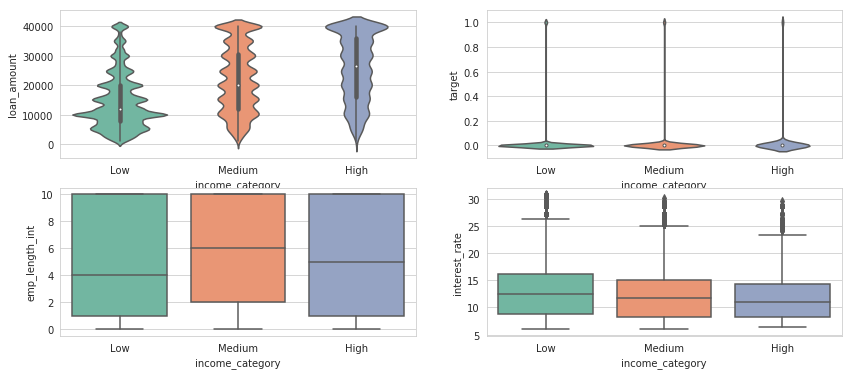

In [28]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(nrows=2, ncols=2, figsize=(14,6))

sns.violinplot(x="income_category", y="loan_amount", data=df, palette="Set2", ax=ax1 )
sns.violinplot(x="income_category", y="target", data=df, palette="Set2", ax=ax2)
sns.boxplot(x="income_category", y="emp_length_int", data=df, palette="Set2", ax=ax3)
sns.boxplot(x="income_category", y="interest_rate", data=df, palette="Set2", ax=ax4)

## analysis by the income category
* Higher income: higher loan amount and lower interest_rate

In [29]:
by_condition = df.groupby('addr_state')['loan_condition'].value_counts()/ df.groupby('addr_state')['loan_condition'].count()
by_emp_length = df.groupby(['region', 'addr_state'], as_index=False).emp_length_int.mean().sort_values(by="addr_state")

loan_condition_bystate = pd.crosstab(df['addr_state'], df['loan_condition'] )

cross_condition = pd.crosstab(df["addr_state"], df["loan_condition"])
# Percentage of condition of loan
percentage_loan_contributor = pd.crosstab(df['addr_state'], df['loan_condition']).apply(lambda x: x/x.sum() * 100)
condition_ratio = cross_condition["Bad Loan"]/cross_condition["Good Loan"]
by_dti = df.groupby(['region', 'addr_state'], as_index=False).dti.mean()
state_codes = sorted(states)


# Take to a list
default_ratio = condition_ratio.values.tolist()
average_dti = by_dti['dti'].values.tolist()
average_emp_length = by_emp_length["emp_length_int"].values.tolist()
number_of_badloans = loan_condition_bystate['Bad Loan'].values.tolist()
percentage_ofall_badloans = percentage_loan_contributor['Bad Loan'].values.tolist()


# Figure Number 2
risk_data = OrderedDict([('state_codes', state_codes),
                         ('default_ratio', default_ratio),
                         ('badloans_amount', number_of_badloans),
                         ('percentage_of_badloans', percentage_ofall_badloans),
                         ('average_dti', average_dti),
                         ('average_emp_length', average_emp_length)])


# Figure 2 Dataframe 
risk_df = pd.DataFrame.from_dict(risk_data)
risk_df = risk_df.round(decimals=3)
risk_df.head()

,state_codes,default_ratio,badloans_amount,percentage_of_badloans,average_dti,average_emp_length
0,AK,0.024,19,0.190,20.691,5.717
1,AL,0.023,96,0.958,22.795,5.463
2,AR,0.035,106,1.058,22.830,5.178
3,AZ,0.026,242,2.415,21.112,4.724
4,CA,0.030,1543,15.398,21.111,5.049


In [30]:
for col in risk_df.columns:
    risk_df[col] = risk_df[col].astype(str)
    
scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],\
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(232, 70, 54)'],[1.0, 'rgb(212, 31, 13)']]

risk_df['text'] = risk_df['state_codes'] + '<br>' +\
'Number of Bad Loans: ' + risk_df['badloans_amount'] + '<br>' + \
'Percentage of all Bad Loans: ' + risk_df['percentage_of_badloans'] + '%' +  '<br>' + \
'Average Debt-to-Income Ratio: ' + risk_df['average_dti'] + '<br>'+\
'Average Length of Employment: ' + risk_df['average_emp_length'] 
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = risk_df['state_codes'],
        z = risk_df['default_ratio'], 
        locationmode = 'USA-states',
        text = risk_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "%")
        ) ]
layout = dict(
    title = 'Lending Clubs Default Rates <br> (Analyzing Risks)',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

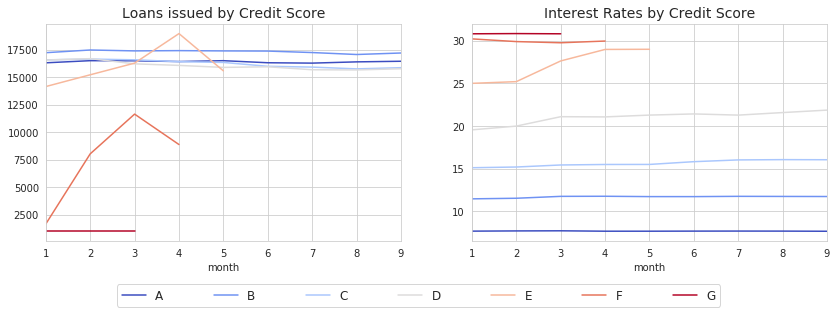

In [31]:
# Let's visualize how many loans were issued by creditscore
f, ((ax1, ax2)) = plt.subplots(1, 2)
cmap = plt.cm.coolwarm

by_credit_score = df.groupby(['month', 'grade']).loan_amount.mean()
by_credit_score.unstack().plot(legend=False, ax=ax1, figsize=(14, 4), colormap=cmap)
ax1.set_title('Loans issued by Credit Score', fontsize=14)
    
    
by_inc = df.groupby(['month', 'grade']).interest_rate.mean()
by_inc.unstack().plot(ax=ax2, figsize=(14, 4), colormap=cmap)
ax2.set_title('Interest Rates by Credit Score', fontsize=14)

ax2.legend(bbox_to_anchor=(-1.0, -0.3, 1.7, 0.1), loc=5, prop={'size':12},
           ncol=9, mode="expand", borderaxespad=0.)

## The Lending club cancel the E/F/G grade category

Text(0, 0.5, 'Interest Rate (%)')

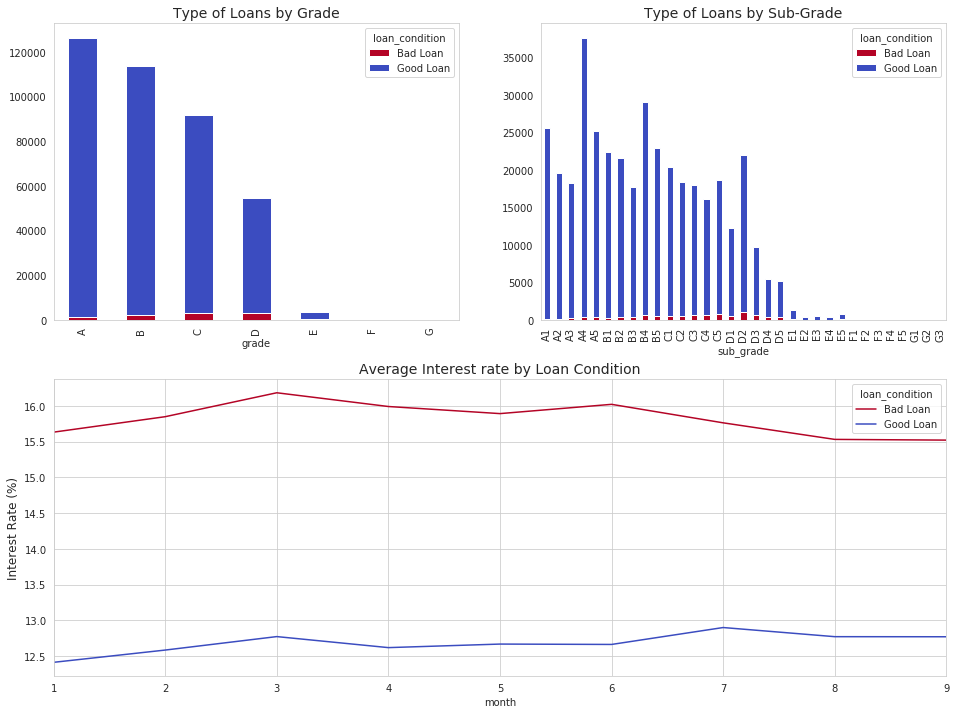

In [32]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

cmap = plt.cm.coolwarm_r

loans_by_region = df.groupby(['grade', 'loan_condition']).size()
loans_by_region.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax1, grid=False)
ax1.set_title('Type of Loans by Grade', fontsize=14)


loans_by_grade = df.groupby(['sub_grade', 'loan_condition']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax2, grid=False)
ax2.set_title('Type of Loans by Sub-Grade', fontsize=14)

by_interest = df.groupby(['month', 'loan_condition']).interest_rate.mean()
by_interest.unstack().plot(ax=ax3, colormap=cmap)
ax3.set_title('Average Interest rate by Loan Condition', fontsize=14)
ax3.set_ylabel('Interest Rate (%)', fontsize=12)

In [33]:
numeric_variables = df.select_dtypes(exclude=["object"])

In [34]:
df_correlations = df.corr()
trace = go.Heatmap(z=df_correlations.values,
                   x=df_correlations.columns,
                   y=df_correlations.columns,
                  colorscale=[[0.0, 'rgb(165,0,38)'], 
                              [0.1111111111111111, 'rgb(215,48,39)'], 
                              [0.2222222222222222, 'rgb(244,109,67)'], 
                              [0.3333333333333333, 'rgb(253,174,97)'], 
                              [0.4444444444444444, 'rgb(254,224,144)'], 
                              [0.5555555555555556, 'rgb(224,243,248)'], 
                              [0.6666666666666666, 'rgb(171,217,233)'], 
                              [0.7777777777777778, 'rgb(116,173,209)'], 
                              [0.8888888888888888, 'rgb(69,117,180)'], 
                              [1.0, 'rgb(49,54,149)']],
            colorbar = dict(
            title = 'Level of Correlation',
            titleside = 'top',
            tickmode = 'array',
            tickvals = [-0.52,0.2,0.95],
            ticktext = ['Negative Correlation','Low Correlation','Positive Correlation'],
            ticks = 'outside'
        )
                  )


layout = {"title": "Correlation Heatmap"}
data=[trace]

fig = dict(data=data, layout=layout)
iplot(fig, filename='labelled-heatmap')

## Coorelation
* more blue or more red, only shows the feature have a strong linear relationship between them!

In [35]:
title = 'Bad Loans: Loan Statuses'

labels = bad_loan # All the elements that comprise a bad loan.

len(labels)
colors = ['rgba(236, 112, 99, 1)', 'rgba(235, 152, 78, 1)', 'rgba(52, 73, 94, 1)', 'rgba(128, 139, 150, 1)',
         'rgba(255, 87, 51, 1)', 'rgba(255, 195, 0, 1)']
mode_size = [8,8,8,8,8,8]
line_size = [2,2,2,2,2,2]
x_data = [
    sorted(df['month'].unique().tolist()),
    sorted(df['month'].unique().tolist()),
    sorted(df['month'].unique().tolist()),
    sorted(df['month'].unique().tolist()), 
]

# type of loans
charged_off = df['loan_amount'].loc[df['loan_status'] == 'Charged Off'].values.tolist()
grace_period = df['loan_amount'].loc[df['loan_status'] == 'In Grace Period'].values.tolist()
short_late = df['loan_amount'].loc[df['loan_status'] == 'Late (16-30 days)'].values.tolist()
long_late = df['loan_amount'].loc[df['loan_status'] == 'Late (31-120 days)'].values.tolist()

y_data = [
    charged_off,
    grace_period,
    short_late,
    long_late,
]

p_charged_off = go.Scatter(
    x = x_data[0],
    y = y_data[0],
    name = 'A. Charged Off',
    line = dict(
        color = colors[0],
        width = 3,
        dash='dash')
)



p_graced = go.Scatter(
    x = x_data[1],
    y = y_data[1],
    name = 'A. Graced Period',
    line = dict(
        color = colors[1],
        width = 3,
        dash='dash')
)

p_short_late = go.Scatter(
    x = x_data[2],
    y = y_data[2],
    name = 'Late (16-30 days)',
    line = dict(
        color = colors[2],
        width = 3,
        dash='dash')
)

p_long_late = go.Scatter(
    x = x_data[3],
    y = y_data[3],
    name = 'Late (31-120 days)',
    line = dict(
        color = colors[3],
        width = 3,
        dash='dash')
)




data=[p_charged_off, p_graced, p_short_late, p_long_late]

layout = dict(title = 'Types of Bad Loans <br> (Amount Borrowed Throughout the Years)',
              xaxis = dict(title = 'Year'),
              yaxis = dict(title = 'Amount Issued'),
              )

fig = dict(data=data, layout=layout)

iplot(fig, filename='line-mode')


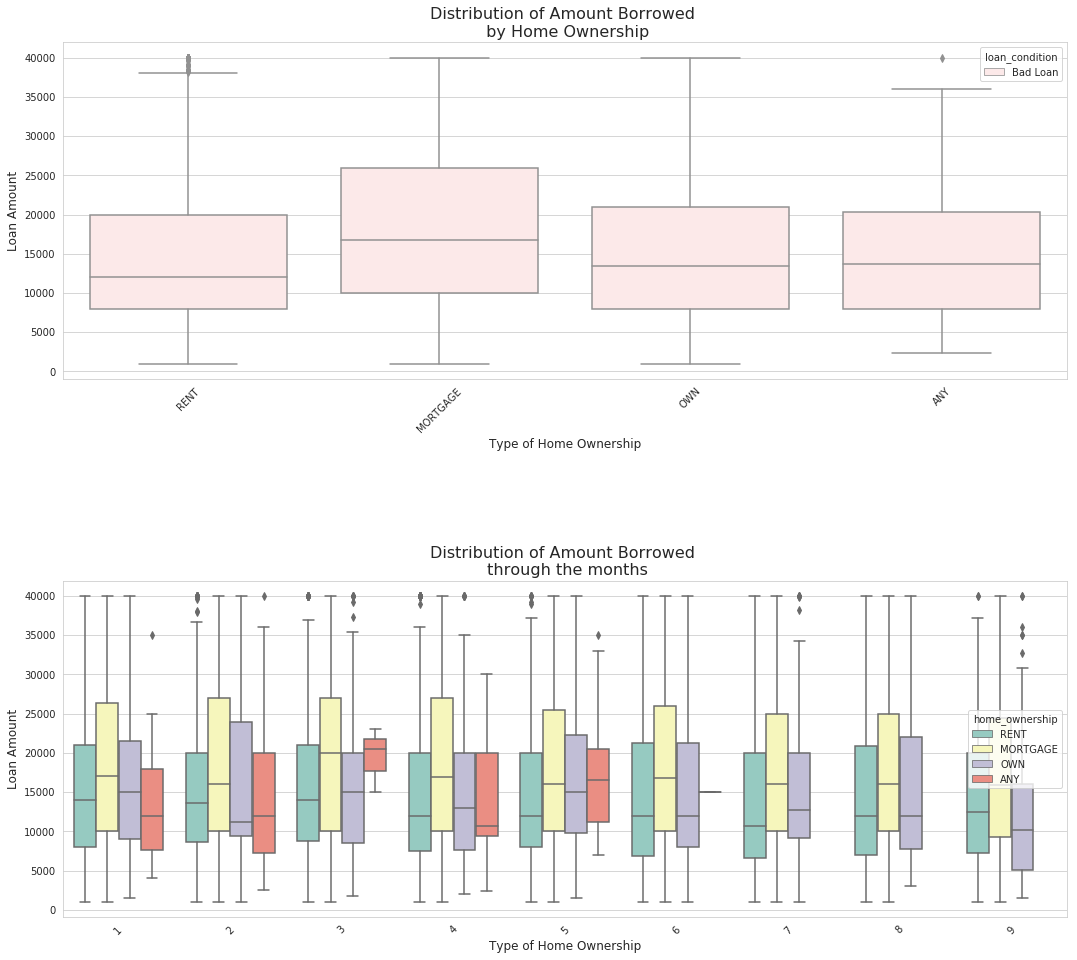

In [36]:
plt.figure(figsize=(18,18))
# Create a dataframe for bad loans
bad_df = df.loc[df['loan_condition'] == 'Bad Loan']

plt.subplot(211)
g = sns.boxplot(x='home_ownership', y='loan_amount', hue='loan_condition',
               data=bad_df, color='r')

g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("Type of Home Ownership", fontsize=12)
g.set_ylabel("Loan Amount", fontsize=12)
g.set_title("Distribution of Amount Borrowed \n by Home Ownership", fontsize=16)



plt.subplot(212)
g1 = sns.boxplot(x='month', y='loan_amount', hue='home_ownership',
               data=bad_df, palette="Set3")
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("Type of Home Ownership", fontsize=12)
g1.set_ylabel("Loan Amount", fontsize=12)
g1.set_title("Distribution of Amount Borrowed \n through the months", fontsize=16)


plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

## From the boxplot
* In the dataset, we notice that there are some outlinear beyond the box. While modeling, should be careful to deal with it


In [37]:
df['purpose'].value_counts()

# Education, renewable energy, wedding are the purposed that contains highest bad loans percent wise.

purpose_condition = round(pd.crosstab(df['loan_condition'], df['purpose']).apply(lambda x: x/x.sum() * 100), 2)

purpose_bad_loans = purpose_condition.values[0].tolist()
purpose_good_loans = purpose_condition.values[1].tolist()
purpose = purpose_condition.columns

bad_plot = go.Bar(
    x=purpose,
    y=purpose_bad_loans,
    name = 'Bad Loans',
    text='%',
    marker=dict(
        color='rgba(219, 64, 82, 0.7)',
        line = dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2
        )
    )
)

good_plot = go.Bar(
    x=purpose,
    y=purpose_good_loans,
    name='Good Loans',
    text='%',
    marker=dict(
        color='rgba(50, 171, 96, 0.7)',
        line = dict(
            color='rgba(50, 171, 96, 1.0)',
            width=2
        )
    )
)


data = [bad_plot, good_plot]

layout = go.Layout(
    title='Condition of Loan by Purpose',
    xaxis=dict(
        title=''
    ),
    yaxis=dict(
        title='% of the Loan',
    ),
    paper_bgcolor='#FFF8DC',
    plot_bgcolor='#FFF8DC',
    showlegend=True
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='condition_purposes')

In [38]:
group_income_purpose = df.groupby(['income_category', 'purpose'], as_index=False).interest_rate.mean()
group_dti_purpose = df.groupby(['income_category', 'purpose'], as_index=False).loan_amount.mean()
loan_a = group_dti_purpose['loan_amount'].values
# High Car 10.32 15669
new_groupby = group_income_purpose.assign(total_loan_amount=loan_a)
sort_group_income_purpose = new_groupby.sort_values(by="income_category", ascending=True)
sort_group_income_purpose.shape

(36, 4)

In [39]:
loan_count = df.groupby(['income_category', 'purpose'])['loan_condition'].apply(lambda x: x.value_counts())
d={"loan_c": loan_count}
loan_c_df = pd.DataFrame(data=d).reset_index()
loan_c_df = loan_c_df.rename(columns={"level_2": "loan_condition"})


# Good loans & Bad Loans
good_loans = loan_c_df.loc[loan_c_df['loan_condition'] == "Good Loan"].sort_values(by="income_category", ascending=True)
bad_loans = loan_c_df.loc[loan_c_df['loan_condition'] == "Bad Loan"].sort_values(by="income_category", ascending=True)
bad_loans = bad_loans.merge(good_loans,on=['income_category', 'purpose'],how='right').drop(['loan_condition_y','loan_c_y'],axis = 1).rename(columns={"loan_condition_x": "loan_condition", 
                        "loan_c_x": "loan_c"})
bad_loans.loan_condition = bad_loans.loan_condition.fillna('Bad Loan')
bad_loans = bad_loans.fillna(0)  ## In 2019 the amount of bad loans is not enough!

sort_group_income_purpose['good_loans_count'] = good_loans['loan_c'].values
sort_group_income_purpose['bad_loans_count'] = bad_loans['loan_c'].values
sort_group_income_purpose['total_loans_issued'] = (good_loans['loan_c'].values + bad_loans['loan_c'].values)
sort_group_income_purpose['bad/good ratio (%)'] = np.around(bad_loans['loan_c'].values / (bad_loans['loan_c'].values + good_loans['loan_c'].values), 4) * 100
final_df = sort_group_income_purpose.sort_values(by='income_category', ascending=True)
final_df.style.background_gradient('coolwarm')

,income_category,purpose,interest_rate,total_loan_amount,good_loans_count,bad_loans_count,total_loans_issued,bad/good ratio (%)
0,High,car,12.2322,19110.9,91,1,92,1.09
5,High,major_purchase,11.9337,22942.7,268,85,353,24.08
1,High,credit_card,10.8643,26490.2,3346,59,3405,1.73
2,High,debt_consolidation,11.8741,27224.7,6664,5,6669,0.07
4,High,house,11.5959,25394.7,154,1,155,0.65
8,High,other,13.0719,21471.3,666,3,669,0.45
3,High,home_improvement,11.6801,24089.2,1452,34,1486,2.29
7,High,moving,12.2517,20209.3,69,6,75,8
9,High,renewable_energy,12.74,19132.5,10,26,36,72.22
10,High,small_business,12.0965,27235.1,252,199,451,44.12


In [40]:
final_df = final_df.sort_values(by="purpose", ascending=False)

In [41]:
# Labels
purpose_labels = df['purpose'].unique()

# Average Interest Rate Dot Plots # 1st Subplot
high_income = final_df['interest_rate'].loc[final_df['income_category'] == 'High'].values.tolist()
medium_income = final_df['interest_rate'].loc[final_df['income_category'] == 'Medium'].values.tolist()
low_income = final_df['interest_rate'].loc[final_df['income_category'] == 'Low'].values.tolist()

high_lst = ['%.2f' % val for val in high_income]
med_lst = ['%.2f' % val for val in medium_income]
low_lst = ['%.2f' % val for val in low_income]



trace1 = {"x": high_lst,
          "y": purpose_labels,
          "marker": {"color": "#0040FF", "size": 16},
          "mode": "markers",
          "name": "High Income",
          "type": "scatter"
}

trace2 = {"x": med_lst,
          "y": purpose_labels,
          "marker": {"color": "#FE9A2E", "size": 16},
          "mode": "markers",
          "name": "Medium Income",
          "type": "scatter",
}

trace3 = {"x": low_lst,
          "y": purpose_labels,
          "marker": {"color": "#FE2E2E", "size": 16},
          "mode": "markers",
          "name": "Low Income",
          "type": "scatter",
}


data = [trace1, trace2, trace3]
layout = {"title": "Average Purpose Interest Rate <br> <i> by Income Category </i> ",
          "xaxis": {"title": "Average Interest Rate", },
          "yaxis": {"title": ""}}

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## Analysis
* Interest Rates: the low income category has a higher interest rate. Something that could possibly explain this is the amount of capital that is needed from other income categories that might explain why the low income categories interest rate for these puposes are lower.
* It is interesting that debt_consolidation have quite low interest for 3 category income people.

In [42]:
# Labels
purpose_labels = final_df['purpose'].unique()

# Amount of Good and Bad Loans per Purpose (fill by income category)
# Good Loans
good_high_cnt = final_df['good_loans_count'].loc[final_df['income_category'] == "High"].values.tolist()
good_med_cnt = final_df['good_loans_count'].loc[final_df['income_category'] == "Medium"].values.tolist()
good_low_cnt = final_df['good_loans_count'].loc[final_df['income_category'] == "Low"].values.tolist()

# Bad Loans
bad_high_cnt = final_df['bad_loans_count'].loc[final_df['income_category'] == "High"].values.tolist()
bad_med_cnt = final_df['bad_loans_count'].loc[final_df['income_category'] == "Medium"].values.tolist()
bad_low_cnt = final_df['bad_loans_count'].loc[final_df['income_category'] == "Low"].values.tolist()


# Good Loans
trace0 = go.Bar(
    y=purpose_labels,
    x=good_high_cnt,
    legendgroup='a',
    name='High Income',
    orientation='h', 
    marker=dict(
        color='#0040FF'
    )
)
trace1 = go.Bar(
    x=good_med_cnt,
    y=purpose_labels,
    legendgroup='a',
    name='Medium Income',
    orientation='h',
    marker=dict(
        color='#FE9A2E',
    )
)

trace2 = go.Bar(
    x=good_low_cnt,
    y=purpose_labels,
    legendgroup='a',
    name='Low Income',
    orientation='h',
    marker=dict(
        color='#FE2E2E',
    )
)

# Bad Loans issued by Income Category
trace3 = go.Bar(
    y=purpose_labels,
    x=bad_high_cnt,
    legendgroup='b',
    showlegend=False,
    name='High Income',
    orientation='h', 
    marker=dict(
        color='#0040FF'
    )
)
trace4 = go.Bar(
    x=bad_med_cnt,
    y=purpose_labels,
    legendgroup='b',
    showlegend=False,
    name='Medium Income',
    orientation='h',
    marker=dict(
        color='#FE9A2E',
    )
)

trace5 = go.Bar(
    x=bad_low_cnt,
    y=purpose_labels,
    legendgroup='b',
    showlegend=False,
    name='Low Income',
    orientation='h',
    marker=dict(
        color='#FE2E2E',
    )
)



fig = tools.make_subplots(rows=2, cols=1, print_grid=False,
                         subplot_titles=("Amount of <br> <i>Good Loans Issued</i>",
                                        "Amount of <br> <i>Bad Loans Issued</i>")
                         )

# First Subplot
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

# Second Subplot
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 1)

fig['layout'].update(height=800, width=800, title='Issuance of Loans', showlegend=True, xaxis=dict(title="Number of Loans Issued"))
iplot(fig, filename='angled-text-bar')

/opt/conda/lib/python3.6/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



## Other and car are the majority of bad loan

In [43]:
# Next task a Radar Chart with the bad/good ratio to see if it justifies the amount of loans issued towards housing
high_ratio = final_df.loc[final_df['income_category'] == 'High']
medium_ratio = final_df.loc[final_df['income_category'] == 'Medium']
low_ratio = final_df.loc[final_df['income_category'] == 'Low']

data = [
    go.Scatterpolar(
        mode='lines+markers',
      r = high_ratio['bad/good ratio (%)'].values.tolist(),
      theta = high_ratio['purpose'].unique(),
      fill = 'toself',
      name = 'High Income',
        line = dict(
        color = "#63AF63"
      ),
      marker = dict(
        color = "#B3FFB3",
        symbol = "square",
        size = 8
      ),
      subplot = "polar",
    ),
    go.Scatterpolar(
        mode='lines+markers',
      r = medium_ratio['bad/good ratio (%)'].values.tolist(),
      theta = medium_ratio['purpose'].unique(),
      fill = 'toself',
      name = 'Medium Income',
        line = dict(
        color = "#C31414"
      ),
      marker = dict(
        color = "#FF5050",
        symbol = "square",
        size = 8
      ),
      subplot = "polar2"
    ),
    go.Scatterpolar(
        mode='lines+markers',
      r = low_ratio['bad/good ratio (%)'].values.tolist(),
      theta = low_ratio['purpose'].unique(),
      fill = 'toself',
      name = 'Low Income',
        line = dict(
        color = "#C9FFC7"
      ),
      marker = dict(
        color = "#8CB28B",
        symbol = "square",
        size = 8
      ),
      subplot = "polar3"
    ),
]

layout = go.Layout(
    title="Bad/Good Ratio <br> (By Purpose)",
    showlegend = False,
     paper_bgcolor = "rgb(255, 206, 153)",
    polar = dict(
      domain = dict(
        x = [0,0.3],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 6
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 6
        ),
        rotation = 90,
        direction = "counterclockwise"
      )
    ),
    polar2 = dict(
      domain = dict(
        x = [0.35,0.65],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 6
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 6
        ),
        rotation = 85,
        direction = "clockwise"
      ),
    ),
    polar3 = dict(
      domain = dict(
        x = [0.7, 1],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 6
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 6
        ),
        rotation = 90,
        direction = "clockwise"
      ),
    ))

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename = "radar/multiple")

## Save Data

In [44]:
# Copy Dataframe
complete_df = df.copy()
complete_df.to_csv('complete_df.csv',index = False)